In [1]:
# load necessary libraries
import pandas as pd 
import glob
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
tg_2020 = pd.read_csv('clean_data/tg_2020.csv')
tg_2022 = pd.read_csv('clean_data/tg_2022.csv')
gt_2020 = pd.read_csv('clean_data/gt_2020.csv')
gt_2022 = pd.read_csv('clean_data/gt_2022.csv')
yt_2020 = pd.read_csv('clean_data/yt_2020.csv')
yt_2022 = pd.read_csv('clean_data/yt_2022.csv')
news_2020 = pd.read_csv('clean_data/news_2020.csv')
news_2022 = pd.read_csv('clean_data/news_2022.csv')
off_2020 = pd.read_csv('clean_data/off_2020.csv')
off_2022 = pd.read_csv('clean_data/off_2022.csv')

In [3]:
# there were inconsistencies in the state names, so this mapping standardizes the state names across all datasets
state_name_map = {
    "México": "Estado de México",
    "Mexico": "Estado de México",
    "Estados Unidos Mexicanos": "Estado de México",
    "Michoacán de Ocampo": "Michoacán",
    "Veracruz de Ignacio de la Llave": "Veracruz",
    "Coahuila de Zaragoza": "Coahuila",
    "Yucatan": "Yucatán",
    "Queretaro": "Querétaro",
    "San Luis Potosi": "San Luis Potosí",
    "Nuevo Leon": "Nuevo León",
    "Michoacan": "Michoacán",
    "Michoacán de Ocampo": "Michoacán"}

for df in [off_2020, off_2022, gt_2020, gt_2022, yt_2020, yt_2022, tg_2020, tg_2022, news_2020, news_2022]:
    df['state'] = df['state'].astype(str).str.strip()
    df['state'] = df['state'].replace(state_name_map)
    df['state'] = df['state'].replace("nan", None)  

In [4]:
# 'state' columns as strings in all dataframes
for df in [off_2020, off_2022, gt_2020, gt_2022, yt_2020, yt_2022, tg_2020, tg_2022, news_2020, news_2022]:
    df['state'] = df['state'].astype(str)

# create dataset for 2020
data_2020 = off_2020.copy()
data_2020['year'] = 2020

# merge Google Trends
data_2020 = data_2020.merge(gt_2020, on='state', how='inner')

# merge YouTube
data_2020 = data_2020.merge(yt_2020, on='state', how='inner')

# merge Telegram
data_2020 = data_2020.merge(tg_2020, on='state', how='inner')

# merge News (=LDA topics)
data_2020 = data_2020.merge(news_2020, on='state', how='inner')


# create dataset for 2022
data_2022 = off_2022.copy()
data_2022['year'] = 2022

# merge Google Trends
data_2022 = data_2022.merge(gt_2022, on='state', how='inner')

# merge YouTube
data_2022 = data_2022.merge(yt_2022, on='state', how='inner')

# merge Telegram
data_2022 = data_2022.merge(tg_2022, on='state', how='inner')

# merge News (=LDA topics)
data_2022 = data_2022.merge(news_2022, on='state', how='inner')

In [5]:
# =============================================
# REGRESSION 1: EDUCATIONAL LAG
# =============================================

# Features for educational lag
educ_features = []

# Google Trends
if 'educational_lag' in data_2020.columns:
    educ_features.append('educational_lag')

# YouTube
if 'educational_lag_avg_sentiment' in data_2020.columns:
    educ_features.append('educational_lag_avg_sentiment')
if 'educational_lag_pct_yt' in data_2020.columns:
    educ_features.append('educational_lag_pct_yt')

# Telegram
if 'educational_lag_pct_tg' in data_2020.columns:
    educ_features.append('educational_lag_pct_tg')

# News topics
if 'women_rights' in data_2020.columns:
    educ_features.append('women_rights')

print(f"Features for educational lag: {educ_features}")

if len(educ_features) > 0 and 'educ_target' in data_2020.columns:
    # Prepare data
    X_educ = data_2020[educ_features].fillna(0)
    y_educ = data_2020['educ_target']
    
    # Standardize features
    scaler_educ = StandardScaler()
    X_educ_scaled = scaler_educ.fit_transform(X_educ)
    
    # Run regression
    model_educ = LinearRegression()
    model_educ.fit(X_educ_scaled, y_educ)
    
    # Predictions and metrics
    y_educ_pred = model_educ.predict(X_educ_scaled)
    r2_educ = r2_score(y_educ, y_educ_pred)
    rmse_educ = np.sqrt(mean_squared_error(y_educ, y_educ_pred))
    
    # Store weights, intercept and scaling parameters
    educ_weights = dict(zip(educ_features, model_educ.coef_))
    educ_intercept = model_educ.intercept_
    educ_scaler_mean = dict(zip(educ_features, scaler_educ.mean_))
    educ_scaler_scale = dict(zip(educ_features, scaler_educ.scale_))
    
    print(f"Educational Lag - R²: {r2_educ:.3f}, RMSE: {rmse_educ:.3f}")
    print("Weights:")
    for feature, weight in educ_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Intercept: {educ_intercept:.4f}")

Features for educational lag: ['educational_lag', 'educational_lag_avg_sentiment', 'educational_lag_pct_yt', 'educational_lag_pct_tg', 'women_rights']
Educational Lag - R²: 0.507, RMSE: 3.621
Weights:
  educational_lag: -3.3722
  educational_lag_avg_sentiment: -1.5724
  educational_lag_pct_yt: 0.7542
  educational_lag_pct_tg: 0.9181
  women_rights: 0.2011
Intercept: 19.1375


In [6]:
# =============================================
# REGRESSION 2: HEALTH
# =============================================

# Features for health
health_features = []

# Google Trends
if 'health_gt' in data_2020.columns:
    health_features.append('health_gt')

# YouTube
if 'access_to_health_services_avg_sentiment' in data_2020.columns:
    health_features.append('access_to_health_services_avg_sentiment')
if 'access_to_health_services_pct_yt' in data_2020.columns:
    health_features.append('access_to_health_services_pct_yt')

# Telegram
if 'access_to_health_services_pct_tg' in data_2020.columns:
    health_features.append('access_to_health_services_pct_tg')

# News topics
if 'health' in data_2020.columns:
    health_features.append('health')

print(f"Features for health: {health_features}")

if len(health_features) > 0 and 'health_target' in data_2020.columns:
    # Prepare data
    X_health = data_2020[health_features].fillna(0)
    y_health = data_2020['health_target']
    
    # Standardize features
    scaler_health = StandardScaler()
    X_health_scaled = scaler_health.fit_transform(X_health)
    
    # Run regression
    model_health = LinearRegression()
    model_health.fit(X_health_scaled, y_health)
    
    # Predictions and metrics
    y_health_pred = model_health.predict(X_health_scaled)
    r2_health = r2_score(y_health, y_health_pred)
    rmse_health = np.sqrt(mean_squared_error(y_health, y_health_pred))
    
    # Store weights, intercept and scaling parameters
    health_weights = dict(zip(health_features, model_health.coef_))
    health_intercept = model_health.intercept_
    health_scaler_mean = dict(zip(health_features, scaler_health.mean_))
    health_scaler_scale = dict(zip(health_features, scaler_health.scale_))
    
    print(f"Health - R²: {r2_health:.3f}, RMSE: {rmse_health:.3f}")
    print("Weights:")
    for feature, weight in health_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Intercept: {health_intercept:.4f}")

Features for health: ['health_gt', 'access_to_health_services_avg_sentiment', 'access_to_health_services_pct_yt', 'access_to_health_services_pct_tg', 'health']
Health - R²: 0.196, RMSE: 5.416
Weights:
  health_gt: -2.3139
  access_to_health_services_avg_sentiment: -2.3958
  access_to_health_services_pct_yt: -0.5648
  access_to_health_services_pct_tg: 1.0547
  health: -1.2084
Intercept: 25.7188


In [7]:
# =============================================
# REGRESSION 3: SOCIAL SECURITY
# =============================================

# Features for social security
social_features = []

# Google Trends
if 'social_gt' in data_2020.columns:
    social_features.append('social_gt')

# YouTube
if 'access_to_social_security_avg_sentiment' in data_2020.columns:
    social_features.append('access_to_social_security_avg_sentiment')
if 'access_to_social_security_pct_yt' in data_2020.columns:
    social_features.append('access_to_social_security_pct_yt')

# Telegram
if 'access_to_social_security_pct_tg' in data_2020.columns:
    social_features.append('access_to_social_security_pct_tg')

# News topics
if 'public_services' in data_2020.columns:
    social_features.append('public_services')
if 'institutions' in data_2020.columns:
    social_features.append('institutions')

print(f"Features for social security: {social_features}")

if len(social_features) > 0 and 'social_target' in data_2020.columns:
    # Prepare data
    X_social = data_2020[social_features].fillna(0)
    y_social = data_2020['social_target']
    
    # Standardize features
    scaler_social = StandardScaler()
    X_social_scaled = scaler_social.fit_transform(X_social)
    
    # Run regression
    model_social = LinearRegression()
    model_social.fit(X_social_scaled, y_social)
    
    # Predictions and metrics
    y_social_pred = model_social.predict(X_social_scaled)
    r2_social = r2_score(y_social, y_social_pred)
    rmse_social = np.sqrt(mean_squared_error(y_social, y_social_pred))
    
    # Store weights, intercept and scaling parameters
    social_weights = dict(zip(social_features, model_social.coef_))
    social_intercept = model_social.intercept_
    social_scaler_mean = dict(zip(social_features, scaler_social.mean_))
    social_scaler_scale = dict(zip(social_features, scaler_social.scale_))
    
    print(f"Social Security - R²: {r2_social:.3f}, RMSE: {rmse_social:.3f}")
    print("Weights:")
    for feature, weight in social_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Intercept: {social_intercept:.4f}")

Features for social security: ['social_gt', 'access_to_social_security_avg_sentiment', 'access_to_social_security_pct_yt', 'access_to_social_security_pct_tg', 'public_services', 'institutions']
Social Security - R²: 0.361, RMSE: 10.845
Weights:
  social_gt: -7.4584
  access_to_social_security_avg_sentiment: -1.5575
  access_to_social_security_pct_yt: 1.1573
  access_to_social_security_pct_tg: -1.0666
  public_services: 1.9059
  institutions: -3.0397
Intercept: 50.7219


In [8]:
# =============================================
# REGRESSION 4: INCOME
# =============================================

# Features for income
income_features = []

# Google Trends
if 'income_gt' in data_2020.columns:
    income_features.append('income_gt')

# YouTube
if 'income_avg_sentiment' in data_2020.columns:
    income_features.append('income_avg_sentiment')
if 'income_pct_yt' in data_2020.columns:
    income_features.append('income_pct_yt')

# Telegram
if 'income_pct_tg' in data_2020.columns:
    income_features.append('income_pct_tg')

# News topics
if 'economy' in data_2020.columns:
    income_features.append('economy')
if 'work' in data_2020.columns:
    income_features.append('work')

print(f"Features for income: {income_features}")

if len(income_features) > 0 and 'income_target' in data_2020.columns:
    # Prepare data
    X_income = data_2020[income_features].fillna(0)
    y_income = data_2020['income_target']
    
    # Standardize features
    scaler_income = StandardScaler()
    X_income_scaled = scaler_income.fit_transform(X_income)
    
    # Run regression
    model_income = LinearRegression()
    model_income.fit(X_income_scaled, y_income)
    
    # Predictions and metrics
    y_income_pred = model_income.predict(X_income_scaled)
    r2_income = r2_score(y_income, y_income_pred)
    rmse_income = np.sqrt(mean_squared_error(y_income, y_income_pred))
    
    # Store weights, intercept and scaling parameters
    income_weights = dict(zip(income_features, model_income.coef_))
    income_intercept = model_income.intercept_
    income_scaler_mean = dict(zip(income_features, scaler_income.mean_))
    income_scaler_scale = dict(zip(income_features, scaler_income.scale_))
    
    print(f"Income - R²: {r2_income:.3f}, RMSE: {rmse_income:.3f}")
    print("Weights:")
    for feature, weight in income_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Intercept: {income_intercept:.4f}")

Features for income: ['income_gt', 'income_avg_sentiment', 'income_pct_yt', 'income_pct_tg', 'economy', 'work']
Income - R²: 0.320, RMSE: 10.354
Weights:
  income_gt: -4.7797
  income_avg_sentiment: 0.1335
  income_pct_yt: -1.9887
  income_pct_tg: 0.6386
  economy: 0.0170
  work: -4.1747
Intercept: 50.7562


In [9]:
# =============================================
# REGRESSION 5: FOOD
# =============================================

# Features for food
food_features = []

# Google Trends
if 'food_gt' in data_2020.columns:
    food_features.append('food_gt')

# YouTube
if 'access_to_food_avg_sentiment' in data_2020.columns:
    food_features.append('access_to_food_avg_sentiment')
if 'access_to_food_pct_yt' in data_2020.columns:
    food_features.append('access_to_food_pct_yt')

# Telegram
if 'access_to_food_pct_tg' in data_2020.columns:
    food_features.append('access_to_food_pct_tg')

# News topics
if 'women_rights' in data_2020.columns:
    food_features.append('women_rights')

print(f"Features for food: {food_features}")

if len(food_features) > 0 and 'food_target' in data_2020.columns:
    # Prepare data
    X_food = data_2020[food_features].fillna(0)
    y_food = data_2020['food_target']
    
    # Standardize features
    scaler_food = StandardScaler()
    X_food_scaled = scaler_food.fit_transform(X_food)
    
    # Run regression
    model_food = LinearRegression()
    model_food.fit(X_food_scaled, y_food)
    
    # Predictions and metrics
    y_food_pred = model_food.predict(X_food_scaled)
    r2_food = r2_score(y_food, y_food_pred)
    rmse_food = np.sqrt(mean_squared_error(y_food, y_food_pred))
    
    # Store weights, intercept and scaling parameters
    food_weights = dict(zip(food_features, model_food.coef_))
    food_intercept = model_food.intercept_
    food_scaler_mean = dict(zip(food_features, scaler_food.mean_))
    food_scaler_scale = dict(zip(food_features, scaler_food.scale_))
    
    print(f"Food - R²: {r2_food:.3f}, RMSE: {rmse_food:.3f}")
    print("Weights:")
    for feature, weight in food_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Intercept: {food_intercept:.4f}")

Features for food: ['food_gt', 'access_to_food_avg_sentiment', 'access_to_food_pct_yt', 'access_to_food_pct_tg', 'women_rights']
Food - R²: 0.174, RMSE: 6.380
Weights:
  food_gt: -1.6228
  access_to_food_avg_sentiment: 2.1920
  access_to_food_pct_yt: 1.4924
  access_to_food_pct_tg: -0.0128
  women_rights: -0.4472
Intercept: 22.8469


In [10]:
# =============================================
# REGRESSION 6: HOUSING
# =============================================

# Features for housing
housing_features = []

# Google Trends
if 'housing_gt' in data_2020.columns:
    housing_features.append('housing_gt')

# YouTube
if 'housing_avg_sentiment' in data_2020.columns:
    housing_features.append('housing_avg_sentiment')
if 'housing_pct_yt' in data_2020.columns:
    housing_features.append('housing_pct_yt')

# Telegram
if 'housing_pct_tg' in data_2020.columns:
    housing_features.append('housing_pct_tg')

# News topics
if 'public_services' in data_2020.columns:
    housing_features.append('public_services')

print(f"Features for housing: {housing_features}")

if len(housing_features) > 0 and 'housing_target' in data_2020.columns:
    # Prepare data
    X_housing = data_2020[housing_features].fillna(0)
    y_housing = data_2020['housing_target']
    
    # Standardize features
    scaler_housing = StandardScaler()
    X_housing_scaled = scaler_housing.fit_transform(X_housing)
    
    # Run regression
    model_housing = LinearRegression()
    model_housing.fit(X_housing_scaled, y_housing)
    
    # Predictions and metrics
    y_housing_pred = model_housing.predict(X_housing_scaled)
    r2_housing = r2_score(y_housing, y_housing_pred)
    rmse_housing = np.sqrt(mean_squared_error(y_housing, y_housing_pred))
    
    # Store weights, intercept and scaling parameters
    housing_weights = dict(zip(housing_features, model_housing.coef_))
    housing_intercept = model_housing.intercept_
    housing_scaler_mean = dict(zip(housing_features, scaler_housing.mean_))
    housing_scaler_scale = dict(zip(housing_features, scaler_housing.scale_))
    
    print(f"Housing - R²: {r2_housing:.3f}, RMSE: {rmse_housing:.3f}")
    print("Weights:")
    for feature, weight in housing_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Intercept: {housing_intercept:.4f}")

Features for housing: ['housing_gt', 'housing_avg_sentiment', 'housing_pct_yt', 'housing_pct_tg', 'public_services']
Housing - R²: 0.096, RMSE: 9.968
Weights:
  housing_gt: -1.9965
  housing_avg_sentiment: 0.2313
  housing_pct_yt: 1.2518
  housing_pct_tg: 2.3376
  public_services: 1.9244
Intercept: 13.7375


In [11]:
# =============================================
# PCA FOR SOCIAL COHESION (PCA loadings as weights as we don't have a target variable) - artificial intercept
# =============================================

# Features for social cohesion
cohesion_features = []

# Google Trends
if 'cohesion_gt' in data_2020.columns:
    cohesion_features.append('cohesion_gt')

# YouTube
if 'social_cohesion_avg_sentiment' in data_2020.columns:
    cohesion_features.append('social_cohesion_avg_sentiment')
if 'social_cohesion_pct_yt' in data_2020.columns:
    cohesion_features.append('social_cohesion_pct_yt')

# Telegram
if 'social_cohesion_pct_tg' in data_2020.columns:
    cohesion_features.append('social_cohesion_pct_tg')

# News topics
if 'safety' in data_2020.columns:
    cohesion_features.append('safety')

print(f"Features for social cohesion: {cohesion_features}")

if len(cohesion_features) > 0:
    # Prepare data
    X_cohesion = data_2020[cohesion_features].fillna(0)
    
    # Standardize
    scaler_cohesion = StandardScaler()
    X_cohesion_scaled = scaler_cohesion.fit_transform(X_cohesion)
    
    # Apply PCA
    pca_cohesion = PCA(n_components=1)
    pca_result = pca_cohesion.fit_transform(X_cohesion_scaled)
    
    pca_scores = pca_result.flatten()
    
    # create an artifical intercept to have only positive weights - need to justify the arbitrary value chosen 
    cohesion_intercept = abs(pca_scores.min()) + 10  
    pca_scores_positive = pca_scores + cohesion_intercept
    
    # use loadings as weights and save scaling parameters
    cohesion_weights = dict(zip(cohesion_features, pca_cohesion.components_[0]))
    cohesion_scaler_mean = dict(zip(cohesion_features, scaler_cohesion.mean_))
    cohesion_scaler_scale = dict(zip(cohesion_features, scaler_cohesion.scale_))
    
    print(f"Social Cohesion - Explained variance: {pca_cohesion.explained_variance_ratio_[0]:.3f}")
    print("PCA Weights:")
    for feature, weight in cohesion_weights.items():
        print(f"  {feature}: {weight:.4f}")
    print(f"Artificial Intercept: {cohesion_intercept:.4f}")
    print(f"Score range after intercept: {pca_scores_positive.min():.3f} to {pca_scores_positive.max():.3f}")

Features for social cohesion: ['cohesion_gt', 'social_cohesion_avg_sentiment', 'social_cohesion_pct_yt', 'social_cohesion_pct_tg', 'safety']
Social Cohesion - Explained variance: 0.335
PCA Weights:
  cohesion_gt: 0.6497
  social_cohesion_avg_sentiment: -0.5884
  social_cohesion_pct_yt: -0.2718
  social_cohesion_pct_tg: 0.2196
  safety: 0.3311
Artificial Intercept: 13.0030
Score range after intercept: 10.000 to 15.613


In [12]:
# save weights, intercepts, and scaling parameters

# Collect all weights with intercepts and scaling parameters
all_weights = []
all_scaling_params = []

# Add regression weights for each dimension
dimensions_data = [
    ('educational_lag', educ_weights if 'educ_weights' in locals() else {}, educ_intercept if 'educ_intercept' in locals() else 0, 
     educ_scaler_mean if 'educ_scaler_mean' in locals() else {}, educ_scaler_scale if 'educ_scaler_scale' in locals() else {}),
    ('health', health_weights if 'health_weights' in locals() else {}, health_intercept if 'health_intercept' in locals() else 0,
     health_scaler_mean if 'health_scaler_mean' in locals() else {}, health_scaler_scale if 'health_scaler_scale' in locals() else {}),
    ('social_security', social_weights if 'social_weights' in locals() else {}, social_intercept if 'social_intercept' in locals() else 0,
     social_scaler_mean if 'social_scaler_mean' in locals() else {}, social_scaler_scale if 'social_scaler_scale' in locals() else {}),
    ('income', income_weights if 'income_weights' in locals() else {}, income_intercept if 'income_intercept' in locals() else 0,
     income_scaler_mean if 'income_scaler_mean' in locals() else {}, income_scaler_scale if 'income_scaler_scale' in locals() else {}),
    ('food', food_weights if 'food_weights' in locals() else {}, food_intercept if 'food_intercept' in locals() else 0,
     food_scaler_mean if 'food_scaler_mean' in locals() else {}, food_scaler_scale if 'food_scaler_scale' in locals() else {}),
    ('housing', housing_weights if 'housing_weights' in locals() else {}, housing_intercept if 'housing_intercept' in locals() else 0,
     housing_scaler_mean if 'housing_scaler_mean' in locals() else {}, housing_scaler_scale if 'housing_scaler_scale' in locals() else {}),
    ('social_cohesion', cohesion_weights if 'cohesion_weights' in locals() else {}, cohesion_intercept if 'cohesion_intercept' in locals() else 0,
     cohesion_scaler_mean if 'cohesion_scaler_mean' in locals() else {}, cohesion_scaler_scale if 'cohesion_scaler_scale' in locals() else {})
]

for dimension, weights_dict, intercept, scaler_mean_dict, scaler_scale_dict in dimensions_data:
    for feature, weight in weights_dict.items():
        all_weights.append({
            'dimension': dimension,
            'feature': feature,
            'weight': weight,
            'method': 'linear_regression' if dimension != 'social_cohesion' else 'pca_with_artificial_intercept',
            'intercept': intercept
        })
        
        # Save scaling parameters for each feature
        if feature in scaler_mean_dict and feature in scaler_scale_dict:
            all_scaling_params.append({
                'dimension': dimension,
                'feature': feature,
                'scaler_mean': scaler_mean_dict[feature],
                'scaler_scale': scaler_scale_dict[feature]
            })

# Create dataframes
weights_df = pd.DataFrame(all_weights)
scaling_df = pd.DataFrame(all_scaling_params)

# Create pivot table for weights
if len(weights_df) > 0:
    weights_pivot = weights_df.pivot(index='feature', columns='dimension', values='weight').fillna(0)

# Save intercepts separately
intercepts_data = []
for dimension, weights_dict, intercept, scaler_mean_dict, scaler_scale_dict in dimensions_data:
    if weights_dict:  # Only if we have weights for this dimension
        intercepts_data.append({
            'dimension': dimension,
            'intercept': intercept
        })

intercepts_df = pd.DataFrame(intercepts_data)

In [13]:
# prepare data 

# Create dictionaries for intercepts 
intercepts_dict = dict(zip(intercepts_df['dimension'], intercepts_df['intercept']))

# Create scaling dictionaries by dimension
scaling_means = {}
scaling_scales = {}

for dimension in scaling_df['dimension'].unique():
    dim_scaling = scaling_df[scaling_df['dimension'] == dimension]
    scaling_means[dimension] = dict(zip(dim_scaling['feature'], dim_scaling['scaler_mean']))
    scaling_scales[dimension] = dict(zip(dim_scaling['feature'], dim_scaling['scaler_scale']))

In [14]:
# apply saved scaling parameters and make nowcasts for each dimension
def predict_dimension(data, dimension, weights_pivot, intercepts_dict, scaling_means, scaling_scales):
    
    # Get weights and intercept
    dimension_weights = weights_pivot[dimension]
    dimension_weights = dimension_weights[dimension_weights != 0]
    intercept = intercepts_dict.get(dimension, 0)
    
    # Collect features and apply saved scaling parameters
    feature_values = []
    feature_names = []
    weights_used = []
    
    for feature, weight in dimension_weights.items():
        
        if feature in data.columns:
            # Get raw values
            raw_values = data[feature].fillna(0).values
            print(f"  Raw values range: {raw_values.min():.4f} to {raw_values.max():.4f}")
        
            if dimension in scaling_means and feature in scaling_means[dimension]:
                saved_mean = scaling_means[dimension][feature]
                saved_scale = scaling_scales[dimension][feature]
                scaled_values = (raw_values - saved_mean) / saved_scale
                
                feature_values.append(scaled_values)
                feature_names.append(feature)
                weights_used.append(weight)
                print(f"   Feature added successfully")
            else:
                print(f"  No scaling parameters found for {feature} in {dimension}")
        else:
            print(f"   Feature {feature} not found in data")
    
    # Create feature matrix and calculate nowcasts
    X_scaled = np.column_stack(feature_values)
    weights_array = np.array(weights_used)
    
    print(f"  X_scaled shape: {X_scaled.shape}")
    print(f"  Weights shape: {weights_array.shape}")
    
    # Calculate nowcasts as weighted sums of components + intercept
    weighted_sum = np.dot(X_scaled, weights_array)
    predictions = weighted_sum + intercept
    
    return predictions, feature_names

# Initialize results dataframe
results_df = pd.DataFrame()
results_df['state'] = data_2022['state']

# Define dimension mappings
dimension_mapping = {
    'educational_lag': 'educ_target',
    'health': 'health_target', 
    'social_security': 'social_target',
    'income': 'income_target',
    'food': 'food_target',
    'housing': 'housing_target'}

# Make nowcasts for each dimension
prediction_results = {}

for dimension, target_col in dimension_mapping.items():
    if target_col in data_2022.columns:
        # Make nowcasts
        predictions, features_used = predict_dimension(
            data_2022, dimension, weights_pivot, intercepts_dict, scaling_means, scaling_scales)
        
        if predictions is not None:
            # store results
            results_df[f'{dimension}_actual'] = data_2022[target_col]
            results_df[f'{dimension}_predicted'] = predictions
            
            # calculate metrics
            actual = data_2022[target_col].values
            
            r2 = r2_score(actual, predictions)
            rmse = np.sqrt(mean_squared_error(actual, predictions))
            mae = mean_absolute_error(actual, predictions)
            
            prediction_results[dimension] = {
                'r2': r2,
                'rmse': rmse,
                'mae': mae,
                'features_used': features_used,
                'n_features': len(features_used) if features_used else 0}
            
            print(f"   R² = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}")
        else:
            print(f"Failed to predict {dimension}")
    else:
        print(f" Target {target_col} not found for {dimension}")


# nowcast social cohesion 
if 'social_cohesion' in weights_pivot.columns:
    
    cohesion_weights = weights_pivot['social_cohesion']
    cohesion_weights = cohesion_weights[cohesion_weights != 0]
    cohesion_intercept = intercepts_dict.get('social_cohesion', 0)
    
    # Apply same logic as other dimensions
    feature_values = []
    feature_names = []
    weights_used = []
    
    for feature, weight in cohesion_weights.items():
        if feature in data_2022.columns:
            raw_values = data_2022[feature].fillna(0).values
            
            if 'social_cohesion' in scaling_means and feature in scaling_means['social_cohesion']:
                saved_mean = scaling_means['social_cohesion'][feature]
                saved_scale = scaling_scales['social_cohesion'][feature]
                scaled_values = (raw_values - saved_mean) / saved_scale
                
                feature_values.append(scaled_values)
                feature_names.append(feature)
                weights_used.append(weight)
                print(f"{feature}: processed successfully")
            else:
                print(f"No scaling parameters for {feature}")
        else:
            print(f" {feature}: not found in data")
    
    if len(feature_values) > 0:
        X_scaled = np.column_stack(feature_values)
        weights_array = np.array(weights_used)
        
        # Calculate cohesion nowcasts
        cohesion_predictions = np.dot(X_scaled, weights_array) + cohesion_intercept
        
        # Store results (no official target for social cohesion)
        results_df['social_cohesion_predicted'] = cohesion_predictions

  Raw values range: 3.5400 to 23.4200
   Feature added successfully
  Raw values range: -0.2623 to 0.0998
   Feature added successfully
  Raw values range: 1.4368 to 15.7447
   Feature added successfully
  Raw values range: 13.2446 to 23.0723
   Feature added successfully
  Raw values range: 0.0063 to 0.4924
   Feature added successfully
  X_scaled shape: (32, 5)
  Weights shape: (5,)
   R² = -0.086, RMSE = 5.181, MAE = 4.211
  Raw values range: -0.5596 to -0.1941
   Feature added successfully
  Raw values range: 9.6154 to 37.6623
   Feature added successfully
  Raw values range: 4.0375 to 9.7040
   Feature added successfully
  Raw values range: 0.0055 to 0.3892
   Feature added successfully
  Raw values range: 3.1200 to 23.3400
   Feature added successfully
  X_scaled shape: (32, 5)
  Weights shape: (5,)
   R² = -1.226, RMSE = 18.558, MAE = 15.099
  Raw values range: -0.5338 to 0.0704
   Feature added successfully
  Raw values range: 12.1495 to 48.5849
   Feature added successfully
  

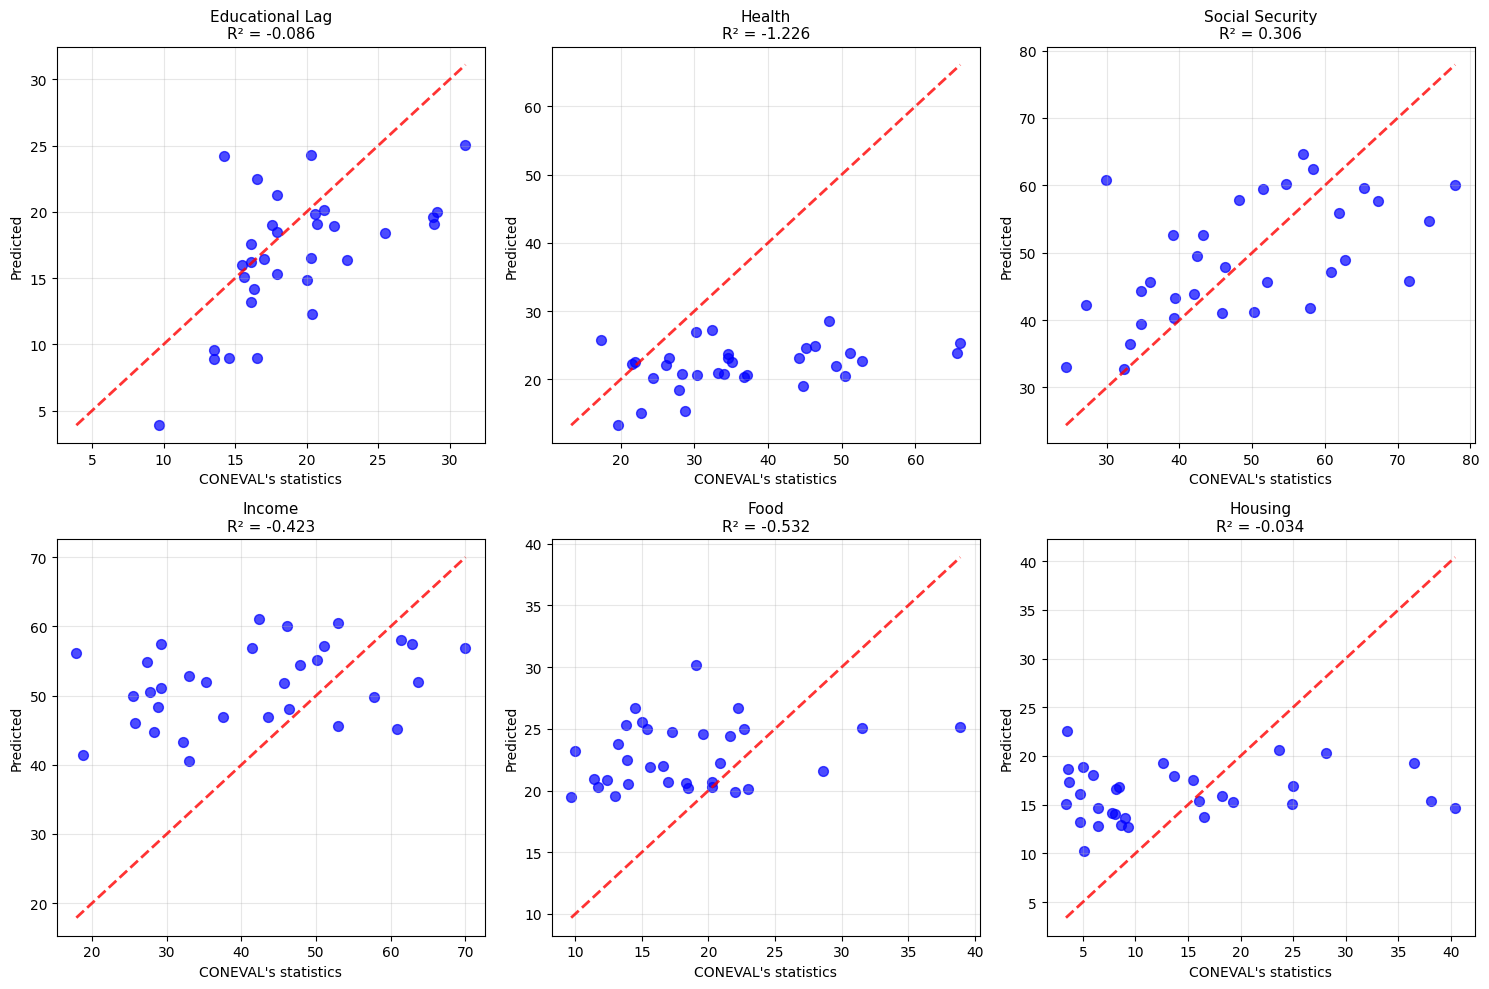

In [15]:
# Save main results
results_df.to_csv('linear_nowcasts/nowcasts_2020_only.csv', index=False)

# Save metrics
metrics_df = pd.DataFrame.from_dict(prediction_results, orient='index')
metrics_df.to_csv('linear_nowcasts/metrics_2020_only.csv')

# Create comparison plots
dimensions_to_plot = [dim for dim in dimension_mapping.keys() if f'{dim}_predicted' in results_df.columns]

if len(dimensions_to_plot) > 0:
    n_plots = len(dimensions_to_plot)
    cols = 3
    rows = (n_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and n_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, dimension in enumerate(dimensions_to_plot):
        ax = axes[i] if n_plots > 1 else axes[0]
        
        actual_col = f'{dimension}_actual'
        pred_col = f'{dimension}_predicted'
        
        if actual_col in results_df.columns and pred_col in results_df.columns:
            x = results_df[actual_col]
            y = results_df[pred_col]
            
            # Scatter plot
            ax.scatter(x, y, alpha=0.7, color='blue', s=50)
            
            # Perfect prediction line
            min_val = min(x.min(), y.min())
            max_val = max(x.max(), y.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
            
            # Calculate R²
            r2 = prediction_results[dimension]['r2']
            
            ax.set_xlabel('CONEVAL\'s statistics', fontsize=10)
            ax.set_ylabel('Predicted', fontsize=10)
            ax.set_title(f'{dimension.replace("_", " ").title()}\nR² = {r2:.3f}', fontsize=11)
            ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(dimensions_to_plot), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('linear_nowcasts/plots_2020_only.png', dpi=300, bbox_inches='tight')
    plt.show()

# Alternative method: PLS Regression

In [16]:
# Map poverty dimensions to target columns
POVERTY_DIMENSIONS = {
    'income': 'income_target',
    'health': 'health_target',
    'education': 'educ_target',
    'social_security': 'social_target',
    'housing': 'housing_target',
    'food': 'food_target'
}

# Get all relevant features for a given dimension
def get_feature_columns(data_2020, dimension):
    feature_cols = []

    prefix_map = {
        'income': 'income',
        'health': 'access_to_health_services',
        'education': 'educational_lag',
        'social_security': 'access_to_social_security',
        'housing': 'housing',
        'food': 'access_to_food',
        'social_cohesion': 'social_cohesion'
    }

    if dimension not in prefix_map:
        print(f"Unknown dimension: {dimension}")
        return []

    base = prefix_map[dimension]

    feature_cols += [col for col in data_2020.columns if col == f'{dimension}_gt']
    feature_cols += [col for col in data_2020.columns if col == f'{base}_avg_sentiment']
    feature_cols += [col for col in data_2020.columns if col == f'{base}_pct_yt']
    feature_cols += [col for col in data_2020.columns if col == f'{base}_pct_tg']

    lda_cols = ['economy', 'women_rights', 'work', 'public_services', 'safety', 'health', 'general_news', 'institutions']
    feature_cols += [col for col in lda_cols if col in data_2020.columns]

    return feature_cols

In [17]:
# Cross-validation to pick optimal number of components
def optimize_pls_components(X, y, max_components=10):
    max_components = min(max_components, len(X) - 1, X.shape[1])
    scores = []
    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n, scale=False)
        mse = -cross_val_score(pls, X, y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()
        scores.append(mse)
    return np.argmin(scores) + 1, scores

In [18]:
# Train final PLS model
def fit_pls_dimension(data_2020, dimension, target_col):
    print(f"\n=== {dimension.upper()} ===")
    feature_cols = get_feature_columns(data_2020, dimension)

    if not feature_cols:
        print("No features found.")
        return None

    X = data_2020[feature_cols].values
    y = data_2020[target_col].values
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[mask], y[mask]

    if len(X) < 10:
        print("Too few valid observations.")
        return None

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    optimal_n, _ = optimize_pls_components(X_scaled, y)
    print(f"Optimal components: {optimal_n}")

    pls = PLSRegression(n_components=optimal_n, scale=False)
    pls.fit(X_scaled, y)
    y_pred = pls.predict(X_scaled).flatten()

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    pearson_r, pearson_p = pearsonr(y, y_pred)
    spearman_r, spearman_p = spearmanr(y, y_pred)

    print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}, Pearson r = {pearson_r:.3f}, Spearman r = {spearman_r:.3f}")

    return {
        'dimension': dimension,
        'model': pls,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'optimal_components': optimal_n,
        'X': X_scaled,
        'y_true': y,
        'y_pred': y_pred,
        'r2': r2,
        'rmse': rmse,
        'pearson_r': pearson_r,
        'spearman_r': spearman_r,
        'states': data_2020.loc[mask, 'state'].values,
        'years': data_2020.loc[mask, 'year'].values}

In [19]:
# Run PLS on all dimensions
pls_results = {}
for dim, target in POVERTY_DIMENSIONS.items():
    if target in data_2020.columns:
        result = fit_pls_dimension(data_2020, dim, target)
        if result:
            pls_results[dim] = result


=== INCOME ===
Optimal components: 1
R² = 0.319, RMSE = 10.356, Pearson r = 0.565, Spearman r = 0.535

=== HEALTH ===
Optimal components: 1
R² = 0.250, RMSE = 5.230, Pearson r = 0.500, Spearman r = 0.470

=== EDUCATION ===
Optimal components: 1
R² = 0.438, RMSE = 3.865, Pearson r = 0.662, Spearman r = 0.666

=== SOCIAL_SECURITY ===
Optimal components: 1
R² = 0.287, RMSE = 11.456, Pearson r = 0.536, Spearman r = 0.513

=== HOUSING ===
Optimal components: 1
R² = 0.198, RMSE = 9.384, Pearson r = 0.446, Spearman r = 0.568

=== FOOD ===
Optimal components: 1
R² = 0.258, RMSE = 6.045, Pearson r = 0.508, Spearman r = 0.586


In [20]:
# Validate models on 2022 only
def validate_2022_predictions(data_2020, pls_results):
    print(f"\nValidation on 2022 — {len(data_2022)} states")
    results = {}

    for dim, res in pls_results.items():
        print(f"\n--- {dim.upper()} ---")
        model = res['model']
        scaler = res['scaler']
        features = res['feature_cols']
        target = POVERTY_DIMENSIONS.get(dim)

        if target not in data_2022.columns:
            continue

        X = data_2022[features].values
        y = data_2022[target].values
        mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
        X, y = X[mask], y[mask]
        states = data_2022['state'].values[mask]

        if len(X) == 0:
            continue

        X_scaled = scaler.transform(X)
        y_pred = model.predict(X_scaled).flatten()

        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = np.mean(np.abs(y - y_pred))
        pearson_r, _ = pearsonr(y, y_pred)
        pct_error = np.mean(np.abs((y - y_pred) / y) * 100)

        print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}, %Error = {pct_error:.1f}%")

        results[dim] = {
            'states': states,
            'y_true': y,
            'y_pred': y_pred,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'mean_pct_error': pct_error,
            'pearson_r': pearson_r}

    return results

In [21]:
# Save predictions and metrics
def save_comprehensive_results(pls_results, validation_results):
    os.makedirs("pls_nowcasts", exist_ok=True)

    # Save predictions
    preds = {'state': next(iter(validation_results.values()))['states']}
    for dim, res in validation_results.items():
        preds[f'{dim}_actual'] = res['y_true']
        preds[f'{dim}_predicted'] = res['y_pred']
    pd.DataFrame(preds).to_csv("pls_nowcasts/nowcasts_2020_only.csv", index=False)

    # Save metrics
    rows = []
    for dim, res in validation_results.items():
        rows.append({
            'dimension': dim,
            'r2': res['r2'],
            'rmse': res['rmse'],
            'mae': res['mae'],
            'mean_pct_error': res['mean_pct_error'],
            'features_used': pls_results[dim]['feature_cols']
        })
    pd.DataFrame(rows).to_csv("pls_nowcasts/metrics_2020_only.csv", index=False)

In [22]:
def create_validation_plot(validation_results):
    if not validation_results:
        return

    cols = 3
    rows = (len(validation_results) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()

    for i, (dim, res) in enumerate(validation_results.items()):
        ax = axes[i]
        ax.scatter(res['y_true'], res['y_pred'], alpha=0.6)
        ax.plot([res['y_true'].min(), res['y_true'].max()],
                [res['y_true'].min(), res['y_true'].max()], 'r--')
        ax.set_title(f"{dim.capitalize()} (2022, R²={res['r2']:.2f})")
        ax.set_xlabel("CONEVAL's statistics")
        ax.set_ylabel("Predicted")
        ax.grid(True)

    for i in range(len(validation_results), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig("pls_nowcasts/plot_2020_only.png", dpi=300)
    plt.show()


Validation on 2022 — 32 states

--- INCOME ---
R² = -0.331, RMSE = 16.082, MAE = 13.538, %Error = 43.7%

--- HEALTH ---
R² = -0.727, RMSE = 16.344, MAE = 12.814, %Error = 30.5%

--- EDUCATION ---
R² = 0.098, RMSE = 4.721, MAE = 3.698, %Error = 19.8%

--- SOCIAL_SECURITY ---
R² = 0.178, RMSE = 12.771, MAE = 10.566, %Error = 25.0%

--- HOUSING ---
R² = 0.079, RMSE = 10.092, MAE = 8.042, %Error = 100.8%

--- FOOD ---
R² = -0.440, RMSE = 7.442, MAE = 6.253, %Error = 40.8%


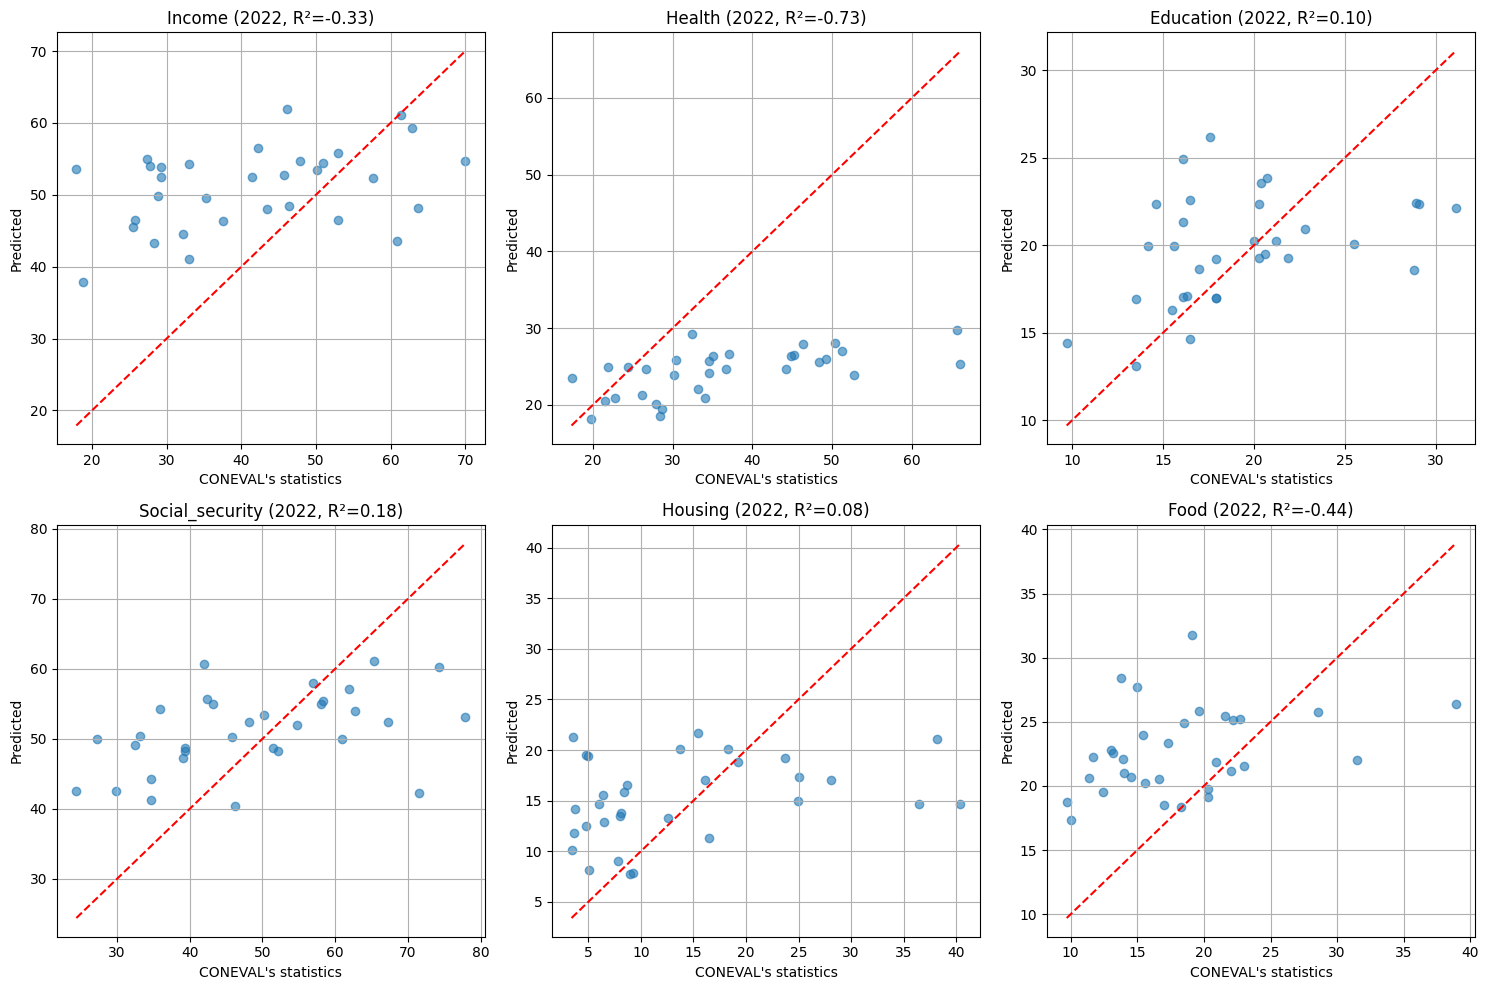


All results saved.


In [23]:
# Run everything
if pls_results:
    validation_2022 = validate_2022_predictions(data_2020, pls_results)

    if validation_2022:
        create_validation_plot(validation_2022)
        save_comprehensive_results(pls_results, validation_2022)
        print("\nAll results saved.")
else:
    print("No PLS models were fitted.")
